<a href="https://colab.research.google.com/github/SETIADEEPANSHU/Atulya-Gamified-Electrical-Appliance-Meter/blob/master/CIFAR_Privacy_Preserving_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ensuring data and model privacy

In most of the industries today having both the required data in the required size, and the in-house Machine Learning expertise is extremely rare. But using third-party data or a third party model poses huge IP and privacy risks.

Using third party data means that the data owner has to send his/her data to the model, and using a third party model means that the model has to be downloaded and loaded. Both of these scenarios expose either the data or the model to the third party.

n this context, one potential solution is to encrypt both the model and the data in a way which allows one organization to use a model owned by another organization without either disclosing their IP to one another. Several encryption schemes exist that allow for computation over encrypted data, among which Secure Multi-Party Computation (SMPC), Homomorphic Encryption (FHE/SHE) and Functional Encryption (FE) are the most well known types. We will focus here on Secure Multi-Party Computation which consists of private additive sharing.


# Scope of the Demo

In this demo we will implement in a simple manner a Privacy-Preserving Prediction model. This model will allow a model trained on some data to make predictions on some other remote third-party data, without revealing anything about the model

It will be divided in 2 parts:

1.   The learning process. We will train a simple Neural Network on the CIFAR dataset
2.   Prediction process. We will demonstrate how this trained model can be applied to another slice of this dataset which lies in a remote machine and provide labeling without revealing the model or the data that is getting fed. Essentially, the model holder (You) cannot see the target data, and the data owners (Bob and Alice) cannot see the model

The end result will be a remote dataset with the predicted labels from the model we trained previously

#Importing and installing the required libraries

Our product is based on open-source code to ensure auditability and transparency. 

We are main contributors in PySyft library, which combines cryptographic protocols such as  Secure Multiparty Computation with PyTorch. The library has been recently featured in the latest F8 of Facebook and there is an upcoming Udacity course on privacy-Preserving Machine Learning based on it

In [1]:
!git clone https://github.com/OpenMined/PySyft.git
%cd PySyft
!pip install -r requirements.txt
# Install the required libraries and do the required tests. 
# Warnings are ok, but if you get an error please contact decentriq
!python setup.py install
!python setup.py test

Cloning into 'PySyft'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 24077 (delta 91), reused 94 (delta 53), pack-reused 23902
Receiving objects: 100% (24077/24077), 30.39 MiB | 23.12 MiB/s, done.
Resolving deltas: 100% (15495/15495), done.
/content/PySyft
     |████████████████████████████████| 368kB 5.0MB/s 
     |████████████████████████████████| 204kB 51.9MB/s 
     |████████████████████████████████| 71kB 25.1MB/s 
     |████████████████████████████████| 450kB 49.7MB/s 
     |████████████████████████████████| 51kB 24.8MB/s 
     |████████████████████████████████| 122kB 50.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/ad/9a/f4/3105b5209674ac77fcca7fede95184c62a95df0196888e0e76
Successfully built zstd
running install
running bdist_egg
running egg_info
creating syft.egg-info
writing syft.egg-info/PKG-INFO
writing dependency_links to syft.egg-info/dependency_links.txt
wr

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt


# The scenario

Imagine that there is a model (you), with a model on some data (small images in this simple example) You wants to sell predictions for this model to two clients ,Bob and Alice who want to use this model architecure for their own image recognition. The current way of doing this is either by you sending the model to Bob and Alice where they would have unlimited access to all the work that you have done on the model (they would be able to see your weights), or by Alice and Bob sending continuously their data over to you in which situation they would share potentially sensitive data to you.

With the current advancements in cryptography and Machine Learning however, there is a third way. Neither you nor them need to share any sensitive information, the model predictions are done on encrypted data while the model is also encrypted.

# Training an image recognition task

In order to conduct privacy-preserving inference, we first have to train a model. The model is trained and tested locally. Meaning that Bob and Alice are not involved in this proccess. 

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 50
        self.epochs = 5
        self.lr = 0.001
        self.log_interval = 100

args = Arguments()


In [0]:
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

def _init_fn():
  return np.random.seed(seed)

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                    #    transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, worker_init_fn=_init_fn)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                    #    transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, worker_init_fn=_init_fn)


0it [00:00, ?it/s]

 99%|█████████▉| 169189376/170498071 [00:39<00:00, 26308541.14it/s]

In [0]:
# INTERNAL NOTE: Working on the network. For now I'm making sure that the whole NB runs from start to end.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 3072)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [0]:
def train(args, model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        output = F.log_softmax(output, dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size,
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

for epoch in range(1, args.epochs + 1):
    train(args, model, train_loader, optimizer, epoch)

Train Epoch: 1 [0/50048 (0%)]	Loss: 2.304078
Train Epoch: 1 [6400/50048 (13%)]	Loss: 1.921039
Train Epoch: 1 [12800/50048 (26%)]	Loss: 1.735386


170500096it [00:50, 26308541.14it/s]                               

Train Epoch: 1 [19200/50048 (38%)]	Loss: 1.940833
Train Epoch: 1 [25600/50048 (51%)]	Loss: 2.075466
Train Epoch: 1 [32000/50048 (64%)]	Loss: 1.812921
Train Epoch: 1 [38400/50048 (77%)]	Loss: 1.975147
Train Epoch: 1 [44800/50048 (90%)]	Loss: 1.774485
Train Epoch: 2 [0/50048 (0%)]	Loss: 1.720586
Train Epoch: 2 [6400/50048 (13%)]	Loss: 1.767773
Train Epoch: 2 [12800/50048 (26%)]	Loss: 1.689665
Train Epoch: 2 [19200/50048 (38%)]	Loss: 1.696862
Train Epoch: 2 [25600/50048 (51%)]	Loss: 1.670267
Train Epoch: 2 [32000/50048 (64%)]	Loss: 1.776497
Train Epoch: 2 [38400/50048 (77%)]	Loss: 1.596704
Train Epoch: 2 [44800/50048 (90%)]	Loss: 1.607974
Train Epoch: 3 [0/50048 (0%)]	Loss: 1.645938
Train Epoch: 3 [6400/50048 (13%)]	Loss: 1.715776
Train Epoch: 3 [12800/50048 (26%)]	Loss: 1.574470
Train Epoch: 3 [19200/50048 (38%)]	Loss: 1.677928
Train Epoch: 3 [25600/50048 (51%)]	Loss: 1.708422
Train Epoch: 3 [32000/50048 (64%)]	Loss: 1.565789
Train Epoch: 3 [38400/50048 (77%)]	Loss: 1.648729
Train Epoch:

In [0]:
def test(args, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
test(args, model, test_loader)


Test set: Average loss: -1.5302, Accuracy: 4663/10000 (47%)



# Privacy Preserving Inference on remote data

After the training and the testing of the model has been done on your side, you are ready now to use it on new data that Alice and Bob hold. As we said, Alice and Bob do not want to give you their raw data because its privacy-sensitive. 

Here we demonstrate how both you and them can benefit from the data and the model respectively while keeping them both private

# Constructing the distributed environment

Our product works with workers, each worker is basically a remote machine that is initialized in the beggining and creates the connection to the library.

Here, since we are working locally (and because its a demo) we are creating two virtual worker() which are acting as virtual seperate machines. We are also creating a worker named "crypto_provider" who is basically an independed machine, which its only job is generating random numbers to be used for the cryptography operations.

It is importand to be stated that **the crypto_provider does not hold any data or any shares of the model**

In our example we name the remote machines (which will hold the real world data) Alice and Bob

In [0]:
import syft as sy
from syft.frameworks.torch.tensors.interpreters import PointerTensor
from syft.frameworks.torch.tensors.decorators import LoggingTensor
import sys


hook = sy.TorchHook(torch) 
client = sy.VirtualWorker(hook, id="client")
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider")

In [0]:
#Since the remote machine in the demo is virtual
#(*Alice and Bob are not real*), we need to send them the that slice of data in the first place
# This is what the code below is doing
private_test_loader = []
for data, target in test_loader:
    private_test_loader.append((
        data.fix_precision().share(alice, bob, crypto_provider=crypto_provider),
        target.fix_precision().share(alice, bob, crypto_provider=crypto_provider) 
    ))

##Model sharing and visualising

In order to do the private prediction we need to split the model in encrypted parts. That way the data owner will not be able to infer the weights of the model while being able to do part of the calculation.

In [0]:
model.fix_precision().share(alice, bob, crypto_provider=crypto_provider)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
)

In [0]:
len(alice._objects)

408

Here we visualize how the data that Bob holds will appear to us. As you can see it is pretty random

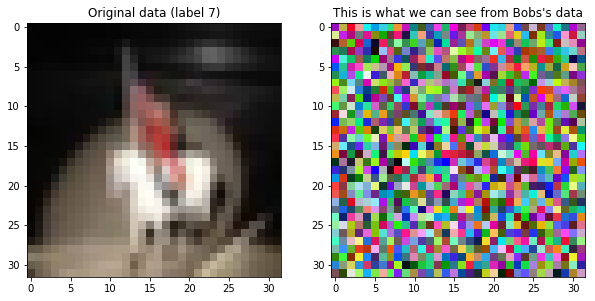

In [0]:
# Fix seed so we always get the same result from the sampler
# seed = 42
# random.seed(seed)            <--
# np.random.seed(seed)         <--
# torch.manual_seed(seed)      <--
# torch.cuda.manual_seed(seed) <-- This BLOCK is messing up wiht the keys

# Getting the plaintext copy of the data
actual_data, actual_label = next(iter(test_loader))

plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title(f"Original data (label {int(actual_label[0])})")
plt.imshow(np.moveaxis(actual_data[0].numpy(), 0, 2))


# Visualzing the secret data

# NOTE: Other thing I'm testing
sample_idx = list(bob._objects.keys())[0]
bob_sample = bob.get_obj(sample_idx).numpy()[0]
bob_sample = bob_sample - bob_sample.min()
bob_sample = bob_sample / bob_sample.max()

plt.subplot(122)
plt.title("This is what we can see from Bobs's data")
plt.imshow(np.moveaxis(bob_sample/bob_sample.max(), 0, -1))
plt.show()

### Testing

Now we do define the test function and we do the privacy-preserving predictions on the last part of the data

In [0]:
def test(args, model, test_loader):
    model.eval()
    n_correct_priv = 0
    n_total = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            output = model(data)
            pred = output.argmax(dim=1) 
            n_correct_priv += pred.eq(target.view_as(pred)).sum() 
            n_total += args.test_batch_size
            # The following test function performs the encrypted evaluation. 
            # The model weights, the data inputs, the prediction and the target 
            # used for scoring are all encrypted! However as you can observe, 
            # the syntax is very similar to normal PyTorch testing! Nice!
            # The only thing we decrypt from the server side is 
            # the final score at the end to verify predictions were on average good.      
            n_correct = n_correct_priv.copy().get().float_precision().long().item()
    
            print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
                n_correct, n_total,
                100. * n_correct / n_total))


In [0]:
test(args, model, private_test_loader)

Test set: Accuracy: 21/50 (42%)
Test set: Accuracy: 43/100 (43%)
Test set: Accuracy: 63/150 (42%)
Test set: Accuracy: 83/200 (42%)
Test set: Accuracy: 107/250 (43%)
Test set: Accuracy: 121/300 (40%)
Test set: Accuracy: 144/350 (41%)
Test set: Accuracy: 166/400 (42%)
Test set: Accuracy: 187/450 (42%)
Test set: Accuracy: 210/500 (42%)
Test set: Accuracy: 233/550 (42%)
Test set: Accuracy: 260/600 (43%)
Test set: Accuracy: 283/650 (44%)
Test set: Accuracy: 310/700 (44%)
Test set: Accuracy: 336/750 (45%)
Test set: Accuracy: 361/800 (45%)
Test set: Accuracy: 386/850 (45%)
Test set: Accuracy: 414/900 (46%)
Test set: Accuracy: 439/950 (46%)
Test set: Accuracy: 463/1000 (46%)
Test set: Accuracy: 491/1050 (47%)
Test set: Accuracy: 520/1100 (47%)
Test set: Accuracy: 544/1150 (47%)
Test set: Accuracy: 559/1200 (47%)
Test set: Accuracy: 584/1250 (47%)
Test set: Accuracy: 610/1300 (47%)
Test set: Accuracy: 634/1350 (47%)
Test set: Accuracy: 657/1400 (47%)
Test set: Accuracy: 682/1450 (47%)
Test set:

As you can see the testing results are of the same accuracy levels as the local test thas has been done above.

**for any questions or feedback contact info@decentriq.ch**